In [1]:
import requests
import numpy as np
import pandas as pd
import psycopg2
from datetime import datetime, date, time
import string
import time
from dateutil import parser
import re
import pytz    
import tzlocal 
import matplotlib.pyplot as plt
import calendar
import matplotlib

pd.options.display.max_columns = 999
%matplotlib inline

# Weather data

In [64]:
# importig the raw file
DF = pd.read_csv('data/RNT.txt')

/Users/eduardodeangelis/anaconda2/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
DF.columns

Index(['station', 'valid', 'tmpf', ' dwpf', ' relh', ' drct', ' sknt', ' p01i',
       ' alti', ' mslp', ' vsby', ' gust', ' skyc1', ' skyc2', ' skyc3',
       ' skyc4', ' skyl1', ' skyl2', ' skyl3', ' skyl4', ' wxcodes', ' metar'],
      dtype='object')

In [66]:
#dropping unuseful columns
DF = DF.drop(columns = [' skyc2', ' skyc3',' skyc4',' skyl2', ' skyl3',' skyl4'])
DF.columns

Index(['station', 'valid', 'tmpf', ' dwpf', ' relh', ' drct', ' sknt', ' p01i',
       ' alti', ' mslp', ' vsby', ' gust', ' skyc1', ' skyl1', ' wxcodes',
       ' metar'],
      dtype='object')

In [79]:
#Converting cloud coverage to numeric

def convert_skyc(string):
    conv_table ={'CLR':0,'SKC':0,'FEW': 0.25,'SCT':0.5,'BKN':0.75,'OVC':1,'M':'M','NSC':0,'VV ':1}
    return conv_table[string]

In [80]:
DF[' skyc1']=DF[' skyc1'].apply(convert_skyc)

Interpretation of cloud coverage (' skyc1')
SKC = Clear (manual report);
CLR = Clear (automated report);
FEW = Few (1/8 to 2/8 of sky covered);
SCT = Scattered (3/8 to 4/8 of sky covered);
BKN = Broken (5/8 to 7/8 of sky covered);
OVC = Overcast (total sky coverage).


In [82]:
#converting strings to numbers
# "erros = 'coerce'" pushes the errors, replacing them with Nan
lst = ['tmpf', ' dwpf', ' relh', ' drct', ' sknt',' p01i',' alti', ' mslp', ' vsby', ' gust',' skyl1',' skyc1']

for col in lst:
    DF[col] = DF[col].apply(pd.to_numeric, errors='coerce')


In [83]:
#converting 'valid' to timestamp and reassiging it as index
DF['valid'] = pd.to_datetime(DF['valid'])
DF = DF.set_index('valid')

In [84]:
# filling missing values with interpolations
for col in lst:
    DF[col]= DF[col].interpolate(method='time', axis=0).ffill().bfill()

## Creating a standardized weather DF (with average values for each 4h)

In [88]:
#Dropping these 3 features that are not part of normal forecasts: Cloud base, gust, sea level pressure and visibility

DF = DF.drop([' gust',' skyl1',' mslp',' vsby'],axis=1)

In [129]:
lst = [' dwpf', ' relh', ' drct', ' sknt',' p01i',' alti', ' skyc1']
BASE = pd.DataFrame(DF.tmpf.resample('4H').mean())

for col in lst:
    ADD = pd.DataFrame(DF[col].resample('4H').mean())
    frames = [BASE,ADD]
    RDF = pd.concat(frames,axis=1)
    BASE = RDF

RDF.head()

,tmpf,dwpf,relh,drct,sknt,p01i,alti,skyc1
valid,,,,,,,,
2013-01-01 00:00:00,30.380,28.460,92.468333,28.333333,0.50,0.0,30.4800,0.333333
2013-01-01 04:00:00,28.535,26.015,90.165000,30.000000,0.75,0.0,30.4600,0.000000
2013-01-01 08:00:00,32.990,29.435,86.862500,42.500000,0.75,0.0,30.4900,0.000000
2013-01-01 12:00:00,41.270,30.965,66.607500,330.000000,6.00,0.0,30.4325,0.000000
2013-01-01 16:00:00,37.490,31.730,79.577500,252.500000,4.75,0.0,30.3900,0.000000


In [130]:
# resetting the index to take the timestamp out
RDF.reset_index(inplace=True)

## splitting date and time

def get_date(ts):
    return ts.date()

def get_hour(ts):
    return ts.hour

RDF['date']=RDF['valid'].apply(get_date)
RDF['hour']=RDF['valid'].apply(get_hour)

In [131]:
RDF.head()

,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,skyc1,date,hour
0,2013-01-01 00:00:00,30.380,28.460,92.468333,28.333333,0.50,0.0,30.4800,0.333333,2013-01-01,0
1,2013-01-01 04:00:00,28.535,26.015,90.165000,30.000000,0.75,0.0,30.4600,0.000000,2013-01-01,4
2,2013-01-01 08:00:00,32.990,29.435,86.862500,42.500000,0.75,0.0,30.4900,0.000000,2013-01-01,8
3,2013-01-01 12:00:00,41.270,30.965,66.607500,330.000000,6.00,0.0,30.4325,0.000000,2013-01-01,12
4,2013-01-01 16:00:00,37.490,31.730,79.577500,252.500000,4.75,0.0,30.3900,0.000000,2013-01-01,16


In [133]:
#Getting one row per day - different rows become columns

RDF = RDF.pivot_table(index='date', 
                    columns='hour',
                    values=['tmpf',' dwpf',' relh',' drct',' sknt',' p01i',' alti',' skyc1'])

### Flattening the multindex DF

In [149]:
RDF = pd.DataFrame(RDF.to_records())

In [ ]:
mi = RDF.columns
mi = list(mi)
mi = mi[1:] #removing 'date' to make it easier

In [223]:
words = re.findall('(\w{4,5})', str(mi))
# hours = re.findall('\d{1,2}',str(mi))
hours = ['0','4','8','12','16','20'] * len(words)
idx = [w + '_' + h for w,h in zip(words,hours)]
idx = ['date']+idx

In [225]:
RDF.columns = idx

In [200]:
for col in idx:
    RDF[col]= RDF[col].interpolate(method='linear', axis=0).ffill().bfill()

In [209]:
# returns day of the year

def doy(dt_obj):
    return int(dt_obj.strftime('%j'))

In [211]:
# creates day of the year column
RDF['doy']=RDF['date'].apply(doy)

In [240]:
RDF.head()

,date,alti_0,alti_4,alti_8,alti_12,alti_16,alti_20,drct_0,drct_4,drct_8,drct_12,drct_16,drct_20,dwpf_0,dwpf_4,dwpf_8,dwpf_12,dwpf_16,dwpf_20,p01i_0,p01i_4,p01i_8,p01i_12,p01i_16,p01i_20,relh_0,relh_4,relh_8,relh_12,relh_16,relh_20,sknt_0,sknt_4,sknt_8,sknt_12,sknt_16,sknt_20,skyc1_0,skyc1_4,skyc1_8,skyc1_12,skyc1_16,skyc1_20,tmpf_0,tmpf_4,tmpf_8,tmpf_12,tmpf_16,tmpf_20,doy
0,2013-01-01,30.480000,30.4600,30.490000,30.4325,30.3900,30.370000,28.333333,30.0,42.5,330.0,252.5,87.500000,28.460,26.015,29.435000,30.965,31.730,29.480,0.00,0.000,0.0,0.0,0.0000,0.000000,92.468333,90.1650,86.862500,66.6075,79.5775,92.162500,0.500000,0.75,0.750000,6.00,4.75,0.750000,0.333333,0.000,0.000000,0.0000,0.0000,0.000000,30.380,28.535,32.990000,41.270,37.490,31.505,1
1,2013-01-02,30.334000,30.2975,30.307500,30.2550,30.2400,30.205000,0.000000,0.0,72.5,150.0,87.5,55.000000,27.896,27.005,27.950000,22.505,20.210,20.255,0.00,0.000,0.0,0.0,0.0000,0.000000,93.774000,93.2300,78.742500,40.0875,45.6400,56.530000,0.000000,0.00,2.000000,5.25,3.25,2.750000,0.150000,0.000,0.000000,0.0000,0.0000,0.000000,29.480,28.715,34.520000,45.500,39.470,34.475,2
2,2013-01-03,30.195000,30.1475,30.140000,30.1150,30.1250,30.152500,70.000000,35.0,120.0,145.0,92.5,30.000000,21.515,24.305,20.525000,19.490,25.205,33.530,0.00,0.000,0.0,0.0,0.0125,0.015000,65.962500,88.6125,47.902500,36.1925,58.6150,86.257500,2.000000,1.00,4.000000,7.00,4.75,1.000000,0.000000,0.000,0.000000,0.0625,0.7500,1.000000,32.225,27.230,38.750000,44.735,39.515,37.265,3
3,2013-01-04,30.208333,30.2580,30.312857,30.2700,30.2125,30.180000,93.333333,138.0,110.0,62.0,0.0,77.500000,35.690,37.634,41.154286,43.736,41.270,38.480,0.01,0.003,0.0,0.0,0.0000,0.000000,93.811667,93.3340,91.638571,83.8080,92.7875,88.002500,2.833333,4.80,3.571429,2.40,0.00,0.750000,0.833333,0.725,0.571429,0.5500,0.1875,0.875000,37.310,39.398,43.442857,48.416,43.250,41.810,4
4,2013-01-05,30.167500,30.1700,30.192500,30.1450,30.1250,30.148889,87.500000,157.5,92.5,150.0,142.5,72.222222,38.480,34.970,33.215000,34.745,32.495,37.860,0.00,0.000,0.0,0.0,0.0000,0.017778,91.625000,76.0925,65.592500,69.7775,66.1850,91.553333,2.750000,3.75,3.500000,5.25,4.00,2.666667,0.875000,0.875,0.937500,0.7500,0.5000,0.666667,40.730,42.260,44.060000,44.015,43.025,40.200,5


[Text(0,0,'Jan'), Text(0,0,'Apr'), Text(0,0,'Jul'), Text(0,0,'Oct')]

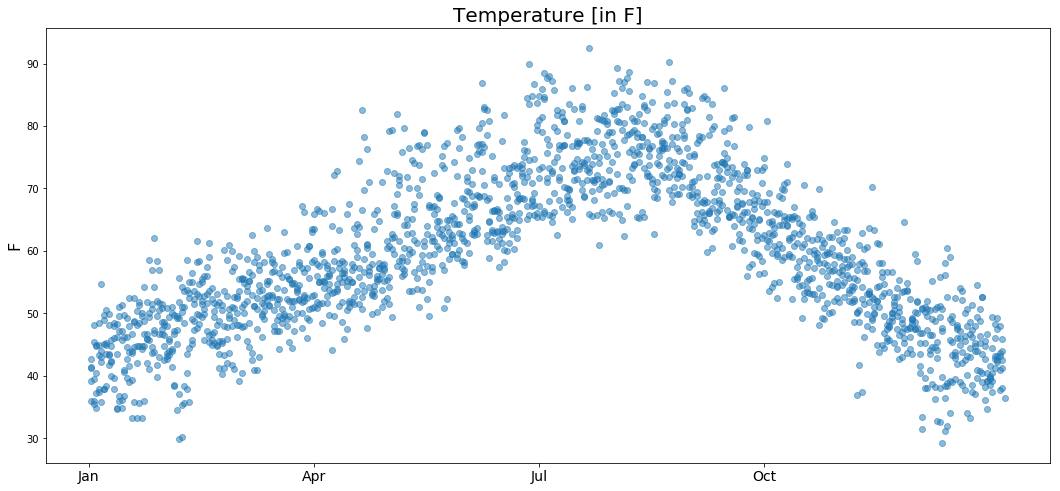

In [230]:
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(RDF['doy'],RDF['tmpf_12'], alpha = 0.5)
ax.set_title('Temperature [in F]',fontsize=20)
ax.set_ylabel('F', fontsize=16)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)

In [231]:
#Sweet way to push DF to Postgres DB


import io

from sqlalchemy import create_engine

# fail, append or replace

def write_to_table(df, db_engine, table_name, if_exists='fail'):
    string_data_io = io.StringIO()
    df.to_csv(string_data_io, sep='|', index=False)
    pd_sql_engine = pd.io.sql.pandasSQL_builder(db_engine)
    table = pd.io.sql.SQLTable(table_name, pd_sql_engine, frame=df,
                               index=False, if_exists=if_exists)
    table.create()
    string_data_io.seek(0)
    string_data_io.readline()  # remove header
    with db_engine.connect() as connection:
        with connection.connection.cursor() as cursor:
            copy_cmd = "COPY %s FROM STDIN HEADER DELIMITER '|' CSV" % table_name
            cursor.copy_expert(copy_cmd, string_data_io)
        connection.connection.commit()

In [238]:
address = 'postgresql://@localhost:5432/soaring_predictor'
engine = create_engine(address)

In [239]:
write_to_table(RDF, engine, 'weather')